In [2]:
from my_app.ensemble import *

# **How to Catch a Scammer**
![picture](pics/pic1.jpg)

In [5]:
df_base = pd.read_pickle('watchex_ban.pkl')

In [6]:
df_mix = pd.read_pickle('merged_grammar.pkl')

# ![](pics/subreddits2.jpg)


## Goals ![](pics/scams.jpg)

* Can I identify a potential scammer based off of their Reddit profile and comment history?
* Find out if scammers use distinctive language compared to non-scammers
* Build an app to predict a user's probability of being a scammer before you buy/sell/trade

## Data Collection

* Collect list of banned users from the Universal Scammer List
* Collect usernames of people who use the buy/sell/trade subreddits
* Collect their Reddit profile information + comment history
* How? PRAW (Python Reddit API Wrapper)


![](pics/usl_leg.jpg)

![](pics/usl.jpg)

## Constraints

* Reddit API internal request limit
* Subscribed user list for subreddits is private
    * Using depth-first search through submission authors and submission comments to collect usernames
* Limited to 1000 requests for comments and submissions per subreddit
    * Sort by Hot, Controversial, New for a potential max of 3000 comments per user, 3000 submissions per subreddit
* Quickly found out that this takes a long time, so I started only with a subset of users while I kept mining
![](pics/watchexample.jpg)

In [51]:
# wanted to see % of negative comments by a user

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
print(sid.polarity_scores('this sucks i hate u'))
print(sid.polarity_scores('wow this is great!!!'))
print(sid.polarity_scores('i am a bot. affirmative human'))

{'neg': 0.861, 'neu': 0.139, 'pos': 0.0, 'compound': -0.7351}
{'neg': 0.0, 'neu': 0.186, 'pos': 0.814, 'compound': 0.8682}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [52]:
def apply_vader(comments):
    scores = defaultdict(int)
    for comment in comments:
        if sid.polarity_scores(comment)['compound'] >= 0.05:
            scores['positive'] += 1
        elif sid.polarity_scores(comment)['compound'] > -0.05 and sid.polarity_scores(comment)['compound'] < 0.05:
            scores['neutral'] += 1
        elif sid.polarity_scores(comment)['compound'] <= -0.05:
            scores['negative'] += 1
        else:
            scores['somethingwrong'] += 1
    return scores

In [55]:
# maybe scammers use worse grammar?

import language_check
tool = language_check.LanguageTool('en-US')
text = 'A sentence with a error in the Hitchhiker’s Guide tot he Galaxy'
matches = tool.check(text)
print(matches[0])
len(matches)


Line 1, column 17, Rule ID: EN_A_VS_AN
Message: Use 'an' instead of 'a' if the following word starts with a vowel sound, e.g. 'an article', 'an hour'
Suggestion: an
A sentence with a error in the Hitchhiker’s Guide tot he ...
                ^


2

In [56]:
df_base.drop(columns = ['comments', 'len_cs', 'grammar', 'cap_freq']).head()

,users,link_karma,comment_karma,verified,mod,gold,days_old,total_comments,positive,neutral,negative,mean_comment_length,mode_comment_length,median_comment_length,duplicate_comments,is_scammer,avg_grammar,total_grammar,cap_freq_mean,comments_new
0,Pellijak,1,-7,False,False,False,2991,20,0.750000,0.150000,0.100000,145.200000,224,224.0,10,True,5.000000,100,0.029018,"Hello Guys,\nMy friend made a paste with trust..."
1,holaquetal12,1,19,True,False,False,810,13,0.692308,0.230769,0.076923,56.769231,9,57.0,0,True,0.615385,8,0.069973,Same here Damn... She sent me a text message t...
2,CalmingTingles,10,42,True,False,False,1294,30,0.233333,0.233333,0.533333,259.800000,753,204.5,1,True,1.800000,54,0.025480,"My thoughts exactly This guy is so toxic, how..."
3,VeronicaClark,1,1,False,False,False,1481,2,0.500000,0.500000,0.000000,50.500000,60,50.5,0,True,4.000000,8,0.000000,i gave you photo proof so i am not a scammer e...
4,nsfwthrwawayy,4870,46,False,False,False,1091,4,0.500000,0.500000,0.000000,26.750000,9,29.5,0,True,0.000000,0,0.100079,#FuckZaza I have IW if you're interested still...


In [82]:
#Tfidf Parameters

tfidf = TfidfVectorizer(
    stop_words='english',
    min_df=3,  # min count for relevant vocabulary
    max_features=5000,  # maximum number of features
    strip_accents='unicode',  # replace all accented unicode char 
    # by their corresponding  ASCII char
    analyzer='word',  # features made of words
    token_pattern=r'[a-zA-Z]{3,}',  # tokenize only words of 3+ chars
     ngram_range=(1, 1),  # features made of a single tokens
    smooth_idf=True,  # prevents zero division for unseen words
    sublinear_tf=False)

In [26]:
e = ensemble(df_base)
e.split(random_state = 1)
e.train_fit()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(e.X, e.y, random_state=1)

In [71]:
mnb_preds = e.MNB_predict(X_test)

In [73]:
# baseline model for naive bayes - wow!

threshold = .25
predicted = mnb_preds >= threshold
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

accuracy: 0.9041450777202072
precision: 0.751937984496124
recall: 0.9509803921568627


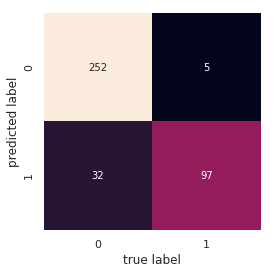

In [74]:
# really promising, need to investigate for leakage

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');


In [107]:
for idx, row in enumerate(mnb_preds):
    if row >= .93:
        print(idx)

166
300


In [85]:
tfidfed = tfidf.fit_transform(e.X['comments_new'])

In [116]:
#300 is highest prob
X_test.iloc[300]['comments']

['I miss him',
 'Id protect it the lil jamal can grow up as a bull ',
 'its a shame he is hacking',
 'Close the door',
 'Since all posts got removed by mods on powertrip here discuss ',
 'Whatever that means,also im not a trump supporter and im banned from the donald',
 'go to /r/conspiracy you nuthead',
 'I miss my cat thx for making me cry',
 'i bet u kiss the girls u faggot',
 'Wow 30 bucks so rich,i could literally get tickets yesterday you inbelic',
 'this was a best of 5 he still lost',
 'Ok',
 'guys im memeing',
 'ram ssd amd cpu',
 "I'd suck that dudes dick",
 "Then maybe just maaaaybe don't exploit him? They knew exactly what they were doing and what can happen and they still did it",
 'all tsm is blaming deathtimers now :^ )',
 'I dont like being told to kill myself for supporting a communist (exact words) ty',
 'Check the last post in my history',
 'I might have skipped that part sorry kinda tired',
 'do u support islam?',
 "I fc'd this map and got instantly restricted :(",


In [88]:
terms = tfidf.get_feature_names()

sanders2016 = tfidf.transform([X_test.iloc[300]['comments_new']])
# sum tfidf frequency of each term through documents
sums = sanders2016.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False)[:10])

#10th ranked word is banned, and the user discusses being banned on other subs

         term      rank
4558   traded  0.351627
1296     dont  0.201560
3157   paypal  0.193247
2369     just  0.192829
125    amazon  0.185264
908   confirm  0.163483
2530     like  0.161698
2173      ill  0.140945
3171   people  0.124556
317    banned  0.113948


![](pics/skype.jpg)

In [246]:
# text = '> Do not trust him. He has scammed me - Via Paypal : pays me 15 dollars, and assumes I am a "scammer" because I didn\'t do a task, even though I had finished it. Be Careful!\n\nNever finished his task did not comply with his word that\'s why I will dispute in paypal to have his account closed by scammer pm to skype tudareleonardo pm to skype tudareleonardo\n pm to skype tudareleonardo\n pm to skype tudareleonardo\n pm to skype tudareleonardo\n Confirmed pm to skype tudareleonardo  Pm.to skype tudareleonardo im interest pm to skype tudareleonardo pm to skype tudareleonardo private message Pm Pm Pm  > Hi i need your service what do i do?\n\nYou have to add me to skype tudareleonardo and there is the verification number Yes i have pm to skype tudareleonardo  Not.  For swagbucks minimun 5 usd Not here you can not since it would be the number on the web you are online? pm to skype tudareleonardo very fastest price minimum 5 usd pm to skype tudareleonardo very fastest price minimum 5 usd pm to skype tudareleonardo very fastest price minimum 5 usd pm to skype tudareleonardo\n pm to skype tudareleonardo pm to skype tudareleonardo price 5usd ??? tell me Pm to skype tudareleonardo  Pm to skype tudareleonardo  Pm to skype tudareleonardo VERIFICATION ver y fastest  Send me to my skype tudareleonardo pm to skype tudareleonardo very fastest verification 5 usd paypal pm to skype tudareleonardo very fastest verification pm to skype tudareleonardo very fastest verification pm to skype tudareleonardo very fastest verification Pm to skype tudareleonardo pm to skype tudareleonardo very fastest verification You really are crazy that if you feel sorry pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo minimum 5usd\n pm to skype tudareleonardo  Pm to skype tudareleonardo Pm to skype tudareleonardo minimun paid 4usd Pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo only gmail pm to skype tudareleonardo minimum tinder price 5 dollar pm to skype tudareleonardo pm t skype tudareleonardo Pm to skype tudareleonardo Pm to skype tudareleonardo VERIFICATION very fast  Pm to skype tudareleonardo Pm to skype tudareleonardo pm to skype tudareleonardo Are you crazy , you are scammed bot Pm to skype tudareleonardo Pm to skype tudareleonardo\n Pm to skyoe tudareleonardo are you crazy gay pm to skype tudareleonardo pm to skype tudareleonardo Pm. To skype tudareleonardo @ThatAstronautGuy This person is bothering in the post that I have created, it is a new account created to annoy, to present evidence of what he says and I return the money if he does not baneenlo Pm to skype tudareleonardo You are a sick, as I told you present the evidence, the community is with me Presents the evidence that you were cheated by me, that I have positive references from people to whom I have verified, we will wait for you Pm to skype tudareleonardo Pm to skype tudareleonardo Pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo 100% security Pm yo skype tudareleonardo Pm yo skype tudareleonardo Pm yo skype tudareleonardo Pm yo skype tudareleonardo Pm.to skype tudareleonardo Pm.to skype tudareleonardo Pm.to skype tudareleonardo Pm.to skype tudareleonardo I\'m not going to pass the number here, I\'m sorry pm to skype tudareleonardo i have tinder verification pm to skype tudareleonardo Pm.yo skype tudareleonardo > You make no sense, create you own thread if you have something to offer!\n\nIs that I thought that you were requesting the service pm to skype tudareleonardo i have numbers for verification tinder Just comment once learn to read spam?? are you crazy yes i accept pm to skype tudareleonardo i have numbers for tinder pm to skype tudareleonardo i have numbers for facebook pm to skype tudareleonardo i have numbers for tinder pm to skype tudareleonardo i have numbers for tinder Pm to skype tudareleonardo Sorry all number internationals funcionally pm to skype tudareleonardo\n Pm to skype tudareleonardo Pm.to skype tudareleonardo Pm.yo skype tudareleonardo i have tinder verification  Pm.to skype tudareleonardo full VERIFICATION  pm to skype tudareleonardo Ok i have to check tinder Pm.whatsapp ir telegram Pm yo skype tudareleonardo, numbers internationals forma verification Pm yo skype tudareleonardo, numbers internationals forma verification hello i have numbers internationals for verification pm to skype tudareleonardo Pm yo skype tudareleonardo, numbers internationals  Pm yo skype tudareleonardo pm to skype tudareleonardo add me on skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo , minimum 5$ pm to skype tudareleonardo Minimun 5 dollars pm yo skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo Pm to skype tudareleonardo pm to skype tudareleonardo i have solutions pm to skype tudareleonardo for tinder minimum 4 dollars pm to skype tudareleonardo If I can verify it but I ask for at least 4 dollars pm to skype tudareleonardo\n pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo Pm yo skype tudareleonardo minimum paid 5dollars pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo minimun 5 dollar numbers security internationals Pm to skype tudareleonardo , numbers internationals  Pm.yo skype tudareleonardo numbers internationals tinder  pm to skype tudareleonardo\n pm to skype tudareleonardo\n pm to skype tudareleonardo numbers internationals verifications Pm So 2$ for phone vertification on paypal us number in needed\n pm to skype tudareleonardo numbers internationals verifications pm to skype tudareleonardo numbers internationals for verifications pm to skype tudareleonardo numbers internationals for verifications pm to skype tudareleonardo I checked your account with international numbers arrive at skype tudareleonardo numbers international minimum 5 dollars to my skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo\n pm to skype tudareleonardo pm to skype tudareleonardo numbers international funtionally Pm to skype tudareleonardo 5 dollars numbers international Pm to skype tudareleonardo 5 dollars numbers international Pm ti skype tudareleonardo 5 dollars numbers international Pm. To skype tudareleonardo minimum 5 dollars tinder\nnumbers internationals Pm. To skype tudareleonardo minimum 5 dollars tinder pm skype tudareleonardo minimun 5 dollars tinder  tinder mp skype tudareleonardo 5$ tinder mp skype tudareleonardo 5$ Tinder minimun 5 dollars pm skype tudareleonardo pm skype tudareleonardo pm to skype tudareleonardo pm to skype tudareleonardo Pm skype tudareleonardo pm skype tudareleonardo pm skipe tudareleonardo pm tudareleonardo skype tudareleonardo Pm 5 dollars minimum skype tudareleonardo pm skype tudareleonardo pm skype tudareleonardo pm skype tudareleonardo can i do it without a USA number I have numbers to see this page to get to skype tudareleonardo 6 dolares PayPal  I have numbers to see this page to get to skype tudareleonardo\n I have  numbers swagbucks you have ? I need verification swagbucks i have numbers ? I need to know if you have numbers to check swagbucks I need to know if you have numbers to check swagbucks I need to know if you have numbers to check swagbucks I need to know if you have numbers to check swagbucks I need to know if you have numbers to check swagbucks'

In [113]:
terms = tfidf.get_feature_names()

lol = tfidf.transform([text])
# sum tfidf frequency of each term through documents
sums = lol.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False)[:10])

# of course skype has the highest weight

               term      rank
4040          skype  0.985586
2980        numbers  0.106210
4748   verification  0.089906
1288        dollars  0.049877
2808        minimum  0.048979
4708            usd  0.030155
2273  international  0.023227
2979         number  0.015747
2918           need  0.015193
711           check  0.014400


In [235]:
print(X_test.iloc[287]['comments'])

faithfulgamer = tfidf.transform([X_test.iloc[287]['comments_new']])
# sum tfidf frequency of each term through documents
sums = faithfulgamer.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False)[:10])

# id'ing on skype

['how do i bump this post ?', 'Add me in skype FaithFulGamer', 'add me in skype faithFulGamer']
           term      rank
4040      skype  0.879556
43          add  0.331396
560        bump  0.307854
3317       post  0.147594
0     abilities  0.000000
3337  practical  0.000000
3336        ppr  0.000000
3335        ppl  0.000000
3334     powers  0.000000
3333   powerful  0.000000


In [114]:
# look at term document matrix for corpus: nothing about bans in the top terms

terms = tfidf.get_feature_names()

# sum tfidf frequency of each term through documents
sums = tfidfed.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False)[:10])

        term        rank
2369    just  201.860924
2530    like  182.849582
4827   watch  168.782296
837      com  164.941542
2132   https  129.614549
1292     don  116.306533
1878    good  106.419780
4449  thanks  101.911526
4496    time   97.997436
2179   imgur   97.691417


In [155]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
X_t = X_train[e.num_cols]
rf.fit(X_t, y_train)
rf_preds = rf.predict_proba(X_test[e.num_cols])[:,1]

In [157]:
xgb = XGBClassifier()
xgb.fit(X_t, y_train)
xgb_y_pred = xgb.predict_proba(X_test[e.num_cols])[:,1]

In [163]:
lgb = LGBMClassifier()
lgb.fit(X_t, y_train)
lgb_y_pred = lgb.predict_proba(X_test[e.num_cols])[:,1]

![](pics/roc_curve.png)

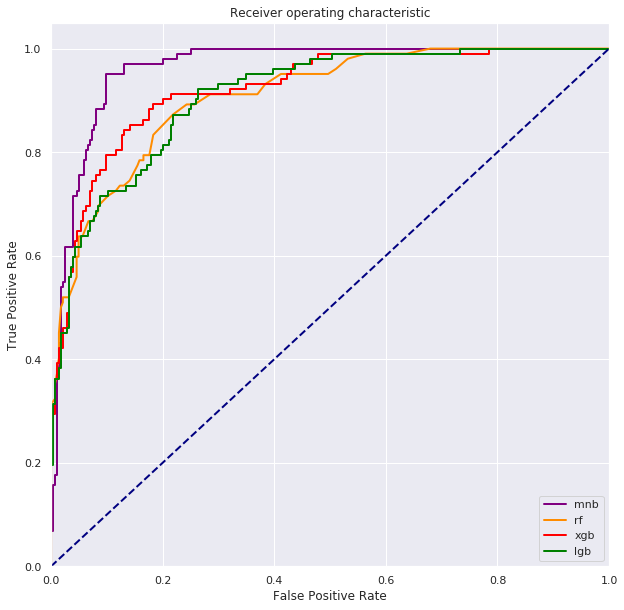

In [164]:
roc_y_test = y_test.map(int)
# MNB
mnb_y_pred = mnb_preds
fpr, tpr, thresholds = roc_curve(roc_y_test, mnb_preds, pos_label=1)
fig,ax = plt.subplots(figsize=(10,10))
plt.plot(fpr, tpr, color='purple',
         lw=2, label='mnb')

#rf
fpr, tpr, thresholds = roc_curve(roc_y_test, rf_preds, pos_label=1)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='rf')
#xgb
fpr, tpr, thresholds = roc_curve(roc_y_test, xgb_y_pred, pos_label=1)
plt.plot(fpr, tpr, color='red',
         lw=2, label='xgb')
#lgb
fpr, tpr, thresholds = roc_curve(roc_y_test, lgb_y_pred, pos_label=1)
plt.plot(fpr, tpr, color='green',
         lw=2, label='lgb')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [171]:
e_probas = e.eclf.predict_proba(X_test[e.num_cols])[:,1]

In [195]:
# score for ensemble method with XGBoost, LGBM, RF trained on all features except actual comment text

threshold = .50
predicted = e_probas >= threshold
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("auc score:", roc_auc_score(y_test,predicted))

accuracy: 0.9559585492227979
precision: 0.9473684210526315
recall: 0.8823529411764706
auc score: 0.9323736536868269


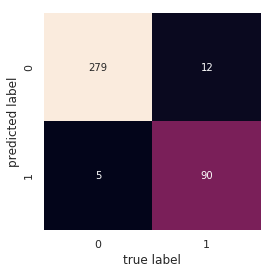

In [173]:
mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [199]:
final_preds = e_probas + mnb_preds / 2

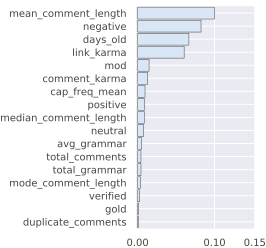

In [176]:
# mean comment length and negative are important features for the rf/gb classifiers

I = importances(e.eclf, X_train[e.num_cols], y_train)
plot_importances(I)

In [177]:
df_base.groupby('is_scammer').mean().T

# can see negative comments is 5% higher for scammers
# mean comment length 50 char difference

is_scammer,False,True
link_karma,3377.491480,3114.585082
comment_karma,4639.712108,12564.270396
verified,0.828700,0.662005
mod,0.090583,0.216783
gold,0.060987,0.032634
days_old,1529.622422,1836.496503
total_comments,529.890583,534.979021
positive,0.548852,0.430924
neutral,0.305084,0.370992
negative,0.146064,0.198083


In [183]:
# p-values low, significant

neg_scammer = df_base.negative[df_base.is_scammer == True].values
neg_users = df_base.negative[df_base.is_scammer == False].values
length_scammer = df_base.mean_comment_length[df_base.is_scammer == True].values
length_users = df_base.mean_comment_length[df_base.is_scammer == False].values

from scipy import stats
print(stats.ttest_ind(neg_scammer,neg_users))
print(stats.ttest_ind(length_scammer,length_users))

Ttest_indResult(statistic=9.066882185130869, pvalue=3.621066314912919e-19)
Ttest_indResult(statistic=-4.426723265437426, pvalue=1.0240079360672573e-05)


accuracy: 0.9585492227979274
precision: 0.8909090909090909
recall: 0.9607843137254902
auc score: 0.9592653962993649


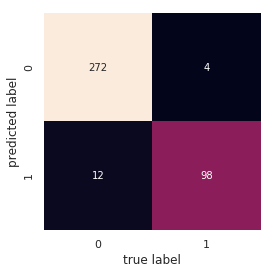

In [201]:
# auc score increased by almost .03 points adding naive bayes to the other classifiers, 
# recall and precision are great!

threshold = .50
predicted = final_preds >= threshold
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("auc score:", roc_auc_score(y_test,predicted))

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

![](pics/mouse.jpeg)

In [185]:
# Import more users from all 60+ subreddits participating in the universal ban list

e2 = ensemble(df_mix)
e2.split()
e2.train_fit()
test_preds = e2.test_predict()

In [240]:
# ensemble model
# precision and recall poor, even with threshold at .25 the recall is only 50%

threshold = .25
predicted = test_preds >= threshold
accuracy = accuracy_score(e2.y_test, predicted)
precision = precision_score(e2.y_test, predicted)
recall = recall_score(e2.y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("auc score:", roc_auc_score(e2.y_test,test_preds))

accuracy: 0.84
precision: 0.4796747967479675
recall: 0.5130434782608696
auc score: 0.8540910647038685


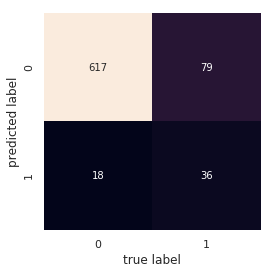

In [193]:
# ouch a lot of false negatives, terrible for a scammer detector

mat = confusion_matrix(e2.y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
test_preds = e2.model.predict_proba(e2.X_test_MNB)[:,1]

In [243]:
# Isolated multinomial naive bayes model
# Doesn't even predict any true labels until .20 threshold, can't separate the groups anymore

threshold = .20
predicted = test_preds >= threshold
accuracy = accuracy_score(e2.y_test, predicted)
precision = precision_score(e2.y_test, predicted)
recall = recall_score(e2.y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("auc score:", roc_auc_score(e2.y_test,test_preds))

accuracy: 0.844
precision: 0.4166666666666667
recall: 0.043478260869565216
auc score: 0.7122629236562821


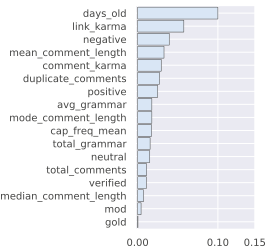

In [204]:
#negative and mean comment length not as important as features anymore

I = importances(e2.eclf, e2.X_train, e2.y_train)
plot_importances(I)

In [227]:
df_mix.groupby('is_scammer').mean().T

#mean comment length and negative comment % similar now

is_scammer,False,True
link_karma,4286.909692,3114.585082
comment_karma,5922.149085,12564.270396
verified,0.836902,0.662005
mod,0.185675,0.216783
gold,0.039315,0.032634
days_old,1206.907357,1836.496503
total_comments,581.841962,534.979021
positive,0.474507,0.430924
neutral,0.346045,0.370992
negative,0.179448,0.198083


In [228]:
neg_scammer = df_mix.negative[df_mix.is_scammer == True].values
neg_users = df_mix.negative[df_mix.is_scammer == False].values
length_scammer = df_mix.mean_comment_length[df_mix.is_scammer == True].values
length_users = df_mix.mean_comment_length[df_mix.is_scammer == False].values

from scipy import stats
print(stats.ttest_ind(neg_scammer,neg_users))
print(stats.ttest_ind(length_scammer,length_users))

# mean comment length not significant anymore, negative still significant but not distinct enough

Ttest_indResult(statistic=3.2520479779977856, pvalue=0.0011584710648988813)
Ttest_indResult(statistic=1.0159228773021844, pvalue=0.30974814696978026)


# What happened?

* Adding more users from a variety of subreddits waters down the comments
    * Initial data was only users from watchexchange and then banned users
    * Most likely separating or identifying scammers based off of demographics that were picked up in the comments
    * Negative speech less distinct as you include users from all parts of Reddit
    
* Possible that I am mislabeling a lot of non-scammers:
    * I'm only labeling users on those buy/trade/sell subreddits that are not banned as a non-scammer, but they might be scammers that haven't been caught yet

# Last thoughts

* Use Selenium to scrape more information that PRAW doesn't not provide
    * Frequent subreddits they comment in or post in
    * Date time of the comments history - Remove comments after ban date
    
* Attempt using other tools such as a neural network to train on comments
    * Seemed to be some merit with naive bayes at first, so it may still be worth investigating with other tools
    * VADER sentiment analyzer was a simple classifier for comments sentiment, could be expanded on
        * Ex. Separating toxic comments vs a comment that shows disagreement being classified as negative
    
* Base parameters for all of the gradient boosted and random forest models, a lot can be done in tuning parameters as well as feature engineering
* Able to build a Flask app, even if the original goal for predicting scammers turns out to futile after more tuning and feature engineering, can easily modify the scripts into a Reddit profile builder

    * Scrape a person's comment history, divide into different sentiments, etc.

# Data Science
## 30%

# Data Engineering
## 50%

# Presentation
## 20%